# GenoSurf API and pyGMQL Example Use Case: 

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
IN_COLAB
if IN_COLAB:
    !pip install git+https://github.com/DEIB-GECO/PyGMQL.git
    !pip install --force https://github.com/chengs/tqdm/archive/colab.zip

In [2]:
import datetime
datetime.datetime.now()

datetime.datetime(2019, 10, 25, 14, 25, 49, 789673)

### Import necessary libraries

In [3]:
from IPython.display import clear_output
import requests
from ast import literal_eval
import pandas as pd
from functools import reduce
import os
from io import StringIO
import gmql as gl
from tqdm import tqdm_notebook as tqdm
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


clear_output()

In [4]:
# set JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## Funtion to download data from GenoSurf

In [5]:
def get_genosurf_results(input_query, payload = {'agg': True}):
    url = 'http://geco.deib.polimi.it/genosurf/api/query/table'
    if type(input_query) == str:
        input_query = literal_eval(input_query)
    response = requests.post(url, json=input_query, params=payload)
    response_json = response.json()
    df = pd.DataFrame(response_json)
    return df

### Funtions to download data from GMQL repository and convert it to gmql dataset

In [6]:
def download_region_file(url,sample_name, other_column_positions =[] ,other_columns = []): #TODO columns and their names
    download_token = '?authToken=DOWNLOAD-TOKEN'
    r = requests.get(url + download_token)
    
    test_string_io = StringIO(r.text)
    column_positions = [0,1,2,3] + other_column_positions
    df2 = pd.read_csv(test_string_io, sep="\t",header=None,usecols=column_positions)
    df2.columns = ['chr', 'start','stop','strand'] + other_columns
    df2['sample_name'] = sample_name    
    return df2

def download_dataset_files(df_genosurf,other_column_positions = [], other_columns = []):
    dfs = [] # can be done by append each iteration
    for index,row in tqdm(list(df_genosurf.iterrows()), desc='Dowloading'):
        dfs.append(download_region_file(row.local_url, row.item_source_id,other_column_positions, other_columns))
    df = pd.concat(dfs)
    return df

def create_dataset(df,meta_df=None, meta_columns=None):
    df = df.copy()
    if meta_df  is not None and meta_columns is not None:
        meta_df = meta_df.copy()
        meta_df['sample_name'] = meta_df['item_source_id']
        meta_df = meta_df.set_index('sample_name')
        meta_df = meta_df[meta_columns]
        meta_df = meta_df.applymap(lambda x: [x] if x else [])
    return gl.from_pandas(df, meta_df ,sample_name='sample_name').to_GMQLDataset()

#### Myc dataset download

#### BRCA dataset download

#### GENE dataset download

#### Loading all DSs from local backup DSs

In [7]:
myc_df = pd.read_csv("backup/myc_df.csv")
myc_dataset_files = pd.read_csv("backup/myc_dataset_files.csv")
myc_dataset = create_dataset(myc_dataset_files)
myc_dataset.head()

brca_df = pd.read_csv("backup/brca_df.csv")
brca_dataset_files = pd.read_csv("backup/brca_dataset_files.csv")
brca_dataset = create_dataset(brca_dataset_files,brca_df,['item_source_id','age','gender','ethnicity','species'])
brca_dataset.head()

gene_df = pd.read_csv("backup/gene_df.csv")
gene_dataset_files = pd.read_csv("backup/gene_dataset_files.csv")
gene_dataset = create_dataset(gene_dataset_files)
gene_dataset.head()

100%|██████████| 2/2 [00:00<00:00, 859.66it/s]


In [8]:
myc = myc_dataset.cover(2, 'ANY')

In [9]:
protein_coding_gene = gene_dataset.select(region_predicate=gene_dataset.gene_biotype=="protein_coding")
prom = protein_coding_gene.reg_project(new_field_dict={'start': protein_coding_gene.start - 5000,
                                                       'stop': protein_coding_gene.start + 1000})

# prom = gene_dataset.reg_project(new_field_dict={'start': gene_dataset.start - 5000,
#                                                        'stop': gene_dataset.start + 1000})

In [10]:
prom_myc = prom.join(myc,genometric_predicate=[gl.DL(0)],output="left")

In [11]:
prom_myc_brca_map = prom_myc.map(brca_dataset,refName='REF_NEW')

In [12]:
prom_myc_brca = prom_myc_brca_map.select(region_predicate=prom_myc_brca_map.count_REF_NEW_EXP > 0)

In [13]:
prom_myc_brca_m = prom_myc_brca.materialize()
print(len(set(prom_myc_brca_m.regs)), len(set(prom_myc_brca_m.regs.index)))

100%|██████████| 8/8 [00:00<00:00, 152.15it/s]

10 76


In [14]:
result_regions = prom_myc_brca_m.regs
result_meta = prom_myc_brca_m.meta

In [15]:
joined = result_regions.join(result_meta)
joined = joined.applymap(lambda x: ''.join(x) if type(x) == list else x )
joined.head()

,chr,start,stop,strand,REF.gene_symbol,REF.gene_biotype,EXP.AccIndex,EXP.JaccardIntersect,EXP.JaccardResult,count_REF_NEW_EXP,REF_NEW.REF.file,REF_NEW.EXP.file,EXP.ethnicity,EXP.item_source_id,EXP.gender,EXP.species,EXP.age
id_sample,,,,,,,,,,,,,,,,,
-9156808363795865683,chr1,156780541,156786541,+,NTRK1,protein_coding,13,0.947368,0.274854,1.0,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723
-9156808363795865683,chr20,61335188,61341188,+,NTSR1,protein_coding,12,0.803815,0.155313,1.0,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723
-9156808363795865683,chr1,156780541,156786541,+,NTRK1,protein_coding,2,0.876652,0.876652,1.0,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723
-9156808363795865683,chr20,61335188,61341188,+,NTSR1,protein_coding,11,0.968750,0.042279,1.0,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723
-9156808363795865683,chr20,61335188,61341188,+,NTSR1,protein_coding,10,0.843558,0.000000,1.0,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723


In [16]:
def convert(s):
    try:
        r = float(s)
        i = int(r)
        if i == r:
            return i
        else:   
            return r
    except ValueError:
        return s

def age_group(x):
    if x <= 55:
        return '25 <= x <= 55'
    elif x <= 65:
        return '55 < x <= 65'
    else:
        return '65 < x <= 100'
    
joined = joined.applymap(convert)
joined

joined['age_number'] = (joined['EXP.age'] / 365)


joined['age'] = (joined['EXP.age'] / 365).map(age_group)
joined.head()

,chr,start,stop,strand,REF.gene_symbol,REF.gene_biotype,EXP.AccIndex,EXP.JaccardIntersect,EXP.JaccardResult,count_REF_NEW_EXP,REF_NEW.REF.file,REF_NEW.EXP.file,EXP.ethnicity,EXP.item_source_id,EXP.gender,EXP.species,EXP.age,age_number,age
id_sample,,,,,,,,,,,,,,,,,,,
-9156808363795865683,chr1,156780541,156786541,+,NTRK1,protein_coding,13,0.947368,0.274854,1,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723,62.254795,55 < x <= 65
-9156808363795865683,chr20,61335188,61341188,+,NTSR1,protein_coding,12,0.803815,0.155313,1,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723,62.254795,55 < x <= 65
-9156808363795865683,chr1,156780541,156786541,+,NTRK1,protein_coding,2,0.876652,0.876652,1,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723,62.254795,55 < x <= 65
-9156808363795865683,chr20,61335188,61341188,+,NTSR1,protein_coding,11,0.968750,0.042279,1,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723,62.254795,55 < x <= 65
-9156808363795865683,chr20,61335188,61341188,+,NTSR1,protein_coding,10,0.843558,0.000000,1,RefSeq_HG19_gene,ENCFF434LJJENCFF808TOFENCFF844RNWENCFF682AWNEN...,white,TCGA-B6-A0X7-01A-11D-A10M-09__dnaseq,female,Homo sapiens,22723,62.254795,55 < x <= 65


In [17]:
joined.groupby('age').nunique()['EXP.item_source_id']

age
25 <= x <= 55    31
55 < x <= 65     25
65 < x <= 100    20
Name: EXP.item_source_id, dtype: int64

In [18]:
pivoted = joined.pivot_table(index ='age', 
                             columns ='REF.gene_symbol', 
                             values ='count_REF_NEW_EXP',
                             fill_value=0,
                             dropna=True, ) 
#                              values =['count_REF_EXP','count_REF_NEW_EXP'],
pivoted.head()

REF.gene_symbol,AASDHPPT,ACOT13,ADAM9,ADGRF2,ADHFE1,AHSP,AIP,ANKRD13D,ANKRD61,AOC2,...,ZFP91,ZFYVE19,ZIC3,ZNF512,ZNF551,ZNF609,ZNF645,ZNF678,ZNRD1,ZSWIM8
age,,,,,,,,,,,,,,,,,,,,,
25 <= x <= 55,0,0,1,1,0,0,0,0,1,1,...,0,1,0,1,0,0,0,1,1,1
55 < x <= 65,1,1,0,0,0,0,1,1,0,0,...,0,0,1,0,0,1,1,0,0,0
65 < x <= 100,0,0,0,0,1,1,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0


In [19]:
pivoted_new = pivoted.copy()


columns1 = pivoted_new.columns[pivoted_new.sum()> 1] 
pivoted_new = pivoted_new[columns1]

# row1 = pivoted_new.T.columns[pivoted_new.sum(axis=1)> 1] 
# pivoted_new = pivoted_new.T[row1].T


pivoted_new

pivoted_new = pivoted_new.T

pivoted_new = pivoted_new[sorted(pivoted_new.columns)]
pivoted_new = pivoted_new.T

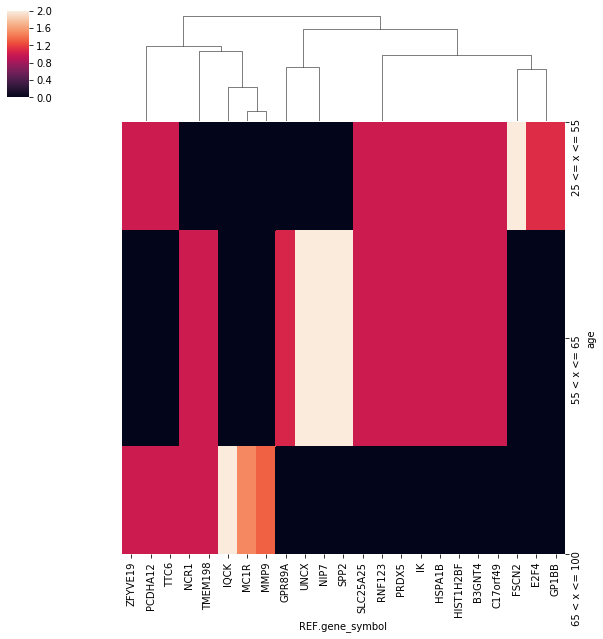

In [20]:
%matplotlib inline

# selected genes cluster

sns.clustermap(pivoted_new,row_cluster=False)
# sns.heatmap(pivoted_new)

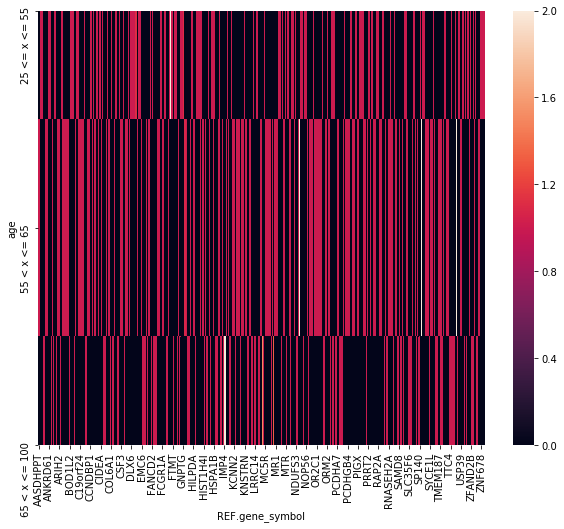

In [21]:
# every gene heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivoted)

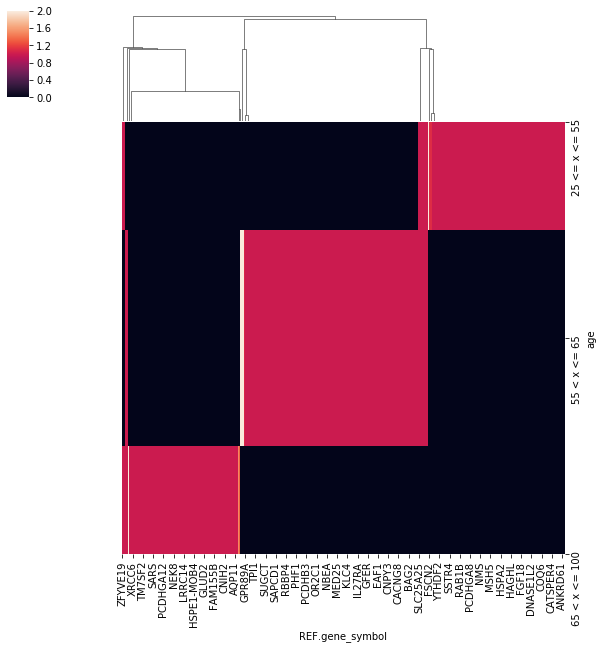

In [22]:
# every gene clustermap
sns.clustermap(pivoted,row_cluster=False)

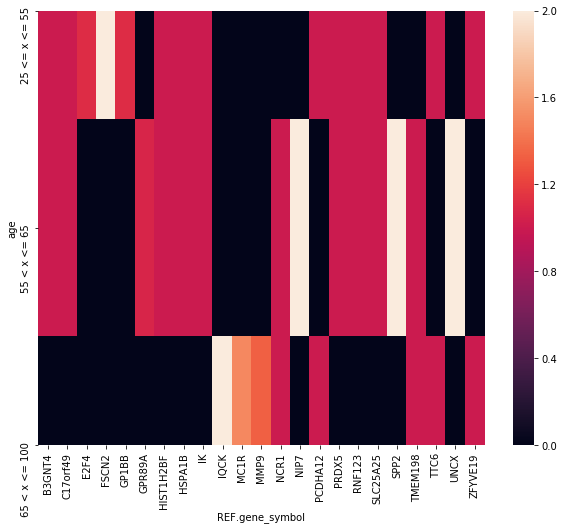

In [23]:
# selected genes heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivoted_new)